# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2024, 5)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2014


In [5]:
if year is None:
    year = cur_year

if last_month is None:
    if year == cur_year:
        last_month = 3
    else:
        last_month = 12

if template is None:
    if year >= 2023:
        template = '2023-PATH-Monthly-Ridership-Report.tabula-template.json'
    else:
        template = 'PATH-Monthly-Ridership-Report.json'

In [6]:
pdf = f'data/{year}-PATH-Monthly-Ridership-Report.pdf'
pdf

'data/2014-PATH-Monthly-Ridership-Report.pdf'

In [7]:
with open(f'templates/{template}', 'r') as f:
    rects = json.load(f)
rects

[{'y1': 121.284, 'x1': 70.016, 'y2': 245.247, 'x2': 568.926},
 {'y1': 261.316, 'x1': 71.546, 'y2': 407.469, 'x2': 569.691},
 {'y1': 482.459, 'x1': 70.781, 'y2': 603.36, 'x2': 568.161},
 {'y1': 620.96, 'x1': 70.781, 'y2': 761.757, 'x2': 569.691}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[121.284, 70.016, 245.247, 568.926],
 [261.316, 71.546, 407.469, 569.691],
 [482.459, 70.781, 603.36, 568.161],
 [620.96, 70.781, 761.757, 569.691]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}

tables

Error importing jpype dependencies. Fallback to subprocess.


No module named 'jpype'


{1: [                    0          1        2       3       4       5
  0  Christopher Street    105,319    3,961   2,327   2,056   2,302
  1           9thStreet    118,521    4,161   3,223   3,046   3,035
  2          14thStreet    223,090    8,231   5,176   4,531   5,700
  3          23rdStreet    190,127    7,765   2,717   2,320   3,458
  4          33rdStreet    861,767   33,711  14,769  12,753  21,871
  5     UPTOWN SUBTOTAL  1,498,824   57,829  28,212  24,706  36,366
  6                 WTC  1,035,731   44,203  10,636   8,699  15,064
  7   NEW YORK SUBTOTAL  2,534,555  102,032  38,848  33,405  51,430,
                       0          1        2       3       4        5
  0               Newark    624,057   25,973   8,458   6,387    9,621
  1             Harrison    158,938    6,621   2,161   1,541    2,544
  2       Journal Square    612,742   23,835  12,345   9,590   12,235
  3         Grove Street    392,390   15,529   7,615   5,588    6,740
  4       Exchange Place    340,67

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 4:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 4 tables
Pg 2: 4 tables
Pg 3: 4 tables
Pg 4: 4 tables
Pg 5: 4 tables
Pg 6: 4 tables
Pg 7: 4 tables
Pg 8: 4 tables
Pg 9: 4 tables
Pg 10: 4 tables
Pg 11: 4 tables
Pg 12: 4 tables


12

In [12]:
avgs = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs['date'] = avgs.date.dt.date
avgs

,0,1,2,3,4,5,date
0,Christopher Street,"105,319","3,961","2,327","2,056","2,302",2014-01-01
1,9thStreet,"118,521","4,161","3,223","3,046","3,035",2014-01-01
2,14thStreet,"223,090","8,231","5,176","4,531","5,700",2014-01-01
3,23rdStreet,"190,127","7,765","2,717","2,320","3,458",2014-01-01
4,33rdStreet,"861,767","33,711","14,769","12,753","21,871",2014-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,"316,221","13,777","1,614","1,134","2,125",2014-12-01
5,Pavonia/ Newport,"484,026","18,143","11,367","8,196","6,618",2014-12-01
6,Hoboken,"681,657","26,316","14,591","10,041","4,173",2014-12-01
7,NEW JERSEY SUBTOTAL,"3,428,222","133,830","65,848","46,056","36,334",2014-12-01


In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

,station,total,avg weekday,avg sat,avg sun,avg holiday,month
0,Christopher Street,105319,3961,2327,2056,2302,2014-01-01
1,9thStreet,118521,4161,3223,3046,3035,2014-01-01
2,14thStreet,223090,8231,5176,4531,5700,2014-01-01
3,23rdStreet,190127,7765,2717,2320,3458,2014-01-01
4,33rdStreet,861767,33711,14769,12753,21871,2014-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,316221,13777,1614,1134,2125,2014-12-01
5,Pavonia/ Newport,484026,18143,11367,8196,6618,2014-12-01
6,Hoboken,681657,26316,14591,10041,4173,2014-12-01
7,NEW JERSEY SUBTOTAL,3428222,133830,65848,46056,36334,2014-12-01


In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station        object
total           int64
avg weekday     int64
avg sat         int64
avg sun         int64
avg holiday     int64
month          object
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[2:]
])
sums['date'] = sums.date.dt.date
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

,station,avg daily,total weekday,total sat,total sun,total holiday,month
0,Christopher Street,3397,83184,9308,8223,4604,2014-01-01
1,9thStreet,3823,87376,12891,12184,6070,2014-01-01
2,14thStreet,7196,172860,20704,18125,11401,2014-01-01
3,23rdStreet,6133,163064,10868,9278,6917,2014-01-01
4,33rdStreet,27799,707937,59077,51011,43742,2014-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,10201,303101,6458,4537,2125,2014-12-01
5,Pavonia/ Newport,15614,399156,45468,32784,6618,2014-12-01
6,Hoboken,21989,578956,58364,40164,4173,2014-12-01
7,NEW JERSEY SUBTOTAL,110588,2944269,263395,184224,36334,2014-12-01


In [17]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [18]:
sums.dtypes

station          object
avg daily         int64
total weekday     int64
total sat         int64
total sun         int64
total holiday     int64
month            object
dtype: object

In [19]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2014-01-01 Christopher Street        3397         3961     2327     2056   
           9thStreet                 3823         4161     3223     3046   
           14thStreet                7196         8231     5176     4531   
           23rdStreet                6133         7765     2717     2320   
           33rdStreet               27799        33711    14769    12753   
...                                   ...          ...      ...      ...   
2014-12-01 Exchange Place           10201        13777     1614     1134   
           Pavonia/ Newport         15614        18143    11367     8196   
           Hoboken                  21989        26316    14591    10041   
           NEW JERSEY SUBTOTAL     110588       133830    65848    46056   
           MONTHLY TOTAL           196770       237435   117210    85523   

                                avg holiday    total  total weekday  \
month      station                                                    
2014-01-01 Christopher Street          2302   105319          83184   
           9thStreet                   3035   118521          87376   
           14thStreet                  5700   223090         172860   
           23rdStreet                  3458   190127         163064   
           33rdStreet                 21871   861767         707937   
...                                     ...      ...            ...   
2014-12-01 Exchange Place              2125   316221         303101   
           Pavonia/ Newport            6618   484026         399156   
           Hoboken                     4173   681657         578956   
           NEW JERSEY SUBTOTAL        36334  3428222        2944269   
           MONTHLY TOTAL              65358  6099863        5223570   

                                total sat  total sun  total holiday  
month      station                                                   
2014-01-01 Christopher Street        9308       8223           4604  
           9thStreet                12891      12184           6070  
           14thStreet               20704      18125          11401  
           23rdStreet               10868       9278           6917  
           33rdStreet               59077      51011          43742  
...                                   ...        ...            ...  
2014-12-01 Exchange Place            6458       4537           2125  
           Pavonia/ Newport         45468      32784           6618  
           Hoboken                  58364      40164           4173  
           NEW JERSEY SUBTOTAL     263395     184224          36334  
           MONTHLY TOTAL           468842     342093          65358  

[204 rows x 10 columns]

In [20]:
path = f'data/{year}.pqt'
df.to_parquet(path)

In [21]:
import plotly.express as px
from IPython.display import Image

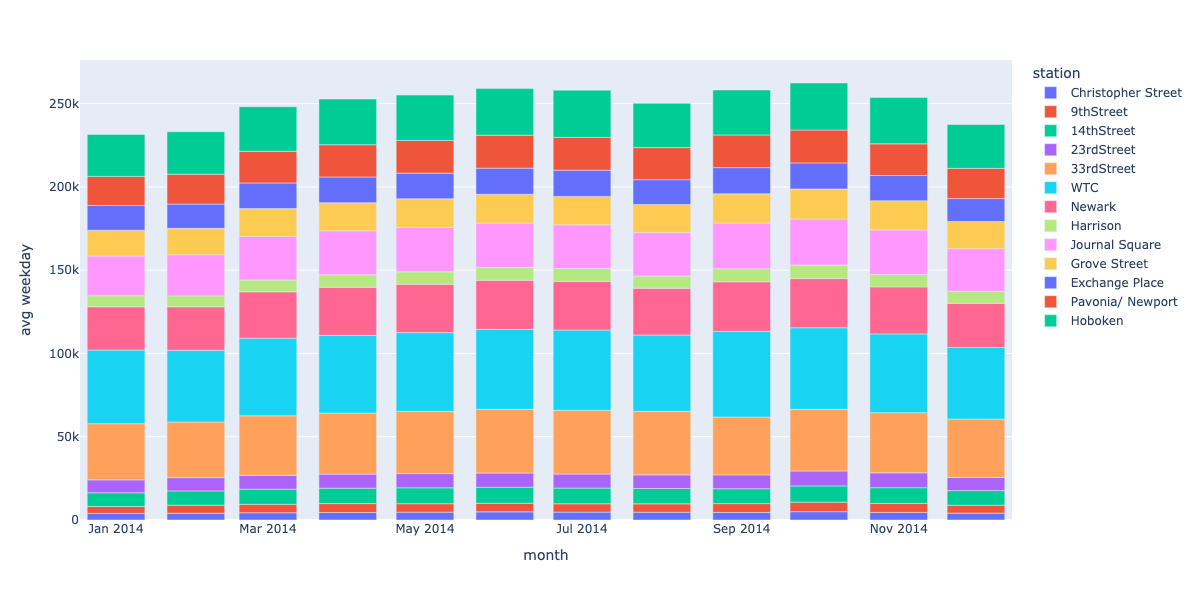

In [22]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))